In [3]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout,Dense,LSTM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load the excel data

df = pd.read_excel('Oil well.xlsx',header=2)
df.head()

,Date,\nOil volume (m3/day),Volume of liquid (m3/day),\nGas volume (m3/day),Water volume (m3/day),Water cut (%),\nWorking hours,\nDynamic level (m),\nReservoir pressure (atm)
0,2013-01-01,49,70,13055,21,29,24,1819,214
1,2013-01-02,49,70,13055,21,29,24,1836,214
2,2013-01-03,49,70,13055,21,29,24,1788,214
3,2013-01-04,49,70,13055,21,29,24,1789,214
4,2013-01-05,44,70,11768,26,36,24,1825,214


In [5]:
# rename the columns

col_mapper = {'\nOil volume (m3/day)':'Oil_volume',
             'Volume of liquid (m3/day)':'Volume_of_liquid',
             '\nGas volume (m3/day)':'Gas_volume',
             'Water volume (m3/day)':'Water_volume',
             'Water cut (%)':'Water_cut',
             '\nWorking hours':'Working_hours',
             '\nDynamic level (m)':'Dynamic_level',
             '\nReservoir pressure (atm)':'Reservoir_pressure'}

df.rename(col_mapper,axis=1,inplace=True)

In [6]:
# set the column names as a lowercase

df.columns = df.columns.str.lower()

In [7]:
# set the date column as index

df.set_index('date',inplace=True)

In [8]:
# select the oil volume column for prediction

df_temp = df['oil_volume'].copy()

In [9]:
df_temp.head()

date
2013-01-01    49
2013-01-02    49
2013-01-03    49
2013-01-04    49
2013-01-05    44
Name: oil_volume, dtype: int64

In [10]:
df_temp.shape

(2939,)

In [11]:
# min max scaling of the input

min_max = MinMaxScaler()

X_train_scaled = min_max.fit_transform(df_temp.values.reshape(-1,1))

In [12]:
X_train_scaled.max()

0.9999999999999999

In [13]:
# create the data

X_train = []
y_train = []

for i in range(60,len(df)):
    X_train.append(X_train_scaled[i-60:i,0])
    y_train.append(X_train_scaled[i,0])

    

In [14]:
import numpy as np

In [15]:
# convert the list into arrays

X_train = np.array(X_train)
print(X_train.shape)

y_train = np.array(y_train)
print(y_train.shape)

(2879, 60)
(2879,)


In [16]:
# reshape the train data for input

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [17]:
# shape of X_train 

X_train.shape

(2879, 60, 1)

In [18]:
# build the model

model = Sequential()

# add the first LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate=0.2))


# add the second LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(rate=0.2))
          
# add the third LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(rate=0.2))

# add fourth LSTM layer
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(rate=0.2))
          
# add output layer
          
model.add(Dense(units=1))
          

In [19]:
# generate the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [20]:
# compile the model

model.compile(optimizer='adam',loss='mean_squared_error',run_eagerly=True)

In [21]:
# fit the model

history = model.fit(X_train,y_train,epochs=5,workers=2)

Epoch 1/5
90/90 [==============================] - 195s 2s/step - loss: 0.0124
Epoch 2/5
90/90 [==============================] - 206s 2s/step - loss: 0.0055
Epoch 3/5
90/90 [==============================] - 193s 2s/step - loss: 0.0054
Epoch 4/5
90/90 [==============================] - 182s 2s/step - loss: 0.0050
Epoch 5/5
90/90 [==============================] - 201s 2s/step - loss: 0.0049


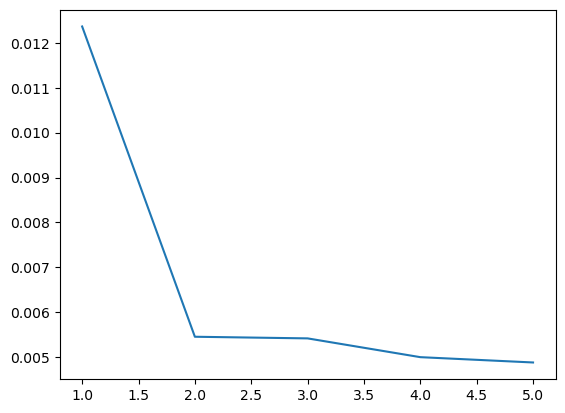

In [22]:
plt.plot(range(1,6),history.history['loss'])
plt.show()

In [23]:
# predict on the train data

y_pred = model.predict(X_train)

90/90 [==============================] - 83s 923ms/step


In [24]:
# shape of the y_pred
y_pred.shape

(2879, 1)

In [25]:
from sklearn.metrics import mean_squared_error

loss = np.sqrt(mean_squared_error(y_train,y_pred))
print('The RMSE is',loss)

The RMSE is 0.05957381923792898


In [26]:
# inverse transform the scaled data

y_pred_inv = min_max.inverse_transform(y_pred)

In [46]:
y_pred_inv.shape

(2879, 1)

In [27]:
x = df_temp.rolling(window=25).mean()

In [28]:
x = x.shift(-10)

In [29]:
x.dropna(inplace=True)

In [30]:
df.columns

Index(['oil_volume', 'volume_of_liquid', 'gas_volume', 'water_volume',
       'water cut (%) ', 'working_hours', 'dynamic_level',
       'reservoir_pressure'],
      dtype='object')

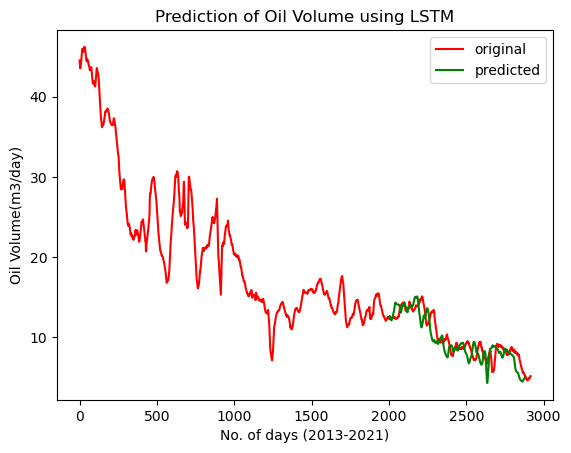

In [50]:
# plot the graph

plt.plot(x.values[:],color='red',label='original')
plt.plot(range(2000,2879),y_pred_inv[2000:],color='green',label='predicted')
plt.legend()
plt.title('Prediction of Oil Volume using LSTM')
plt.xlabel('No. of days (2013-2021)')
plt.ylabel('Oil Volume(m3/day)')
plt.savefig('prediction.png')

In [32]:
x.values.shape

(2915,)

In [33]:
combined = np.concatenate([x.values.ravel()[0:2000],y_pred_inv.ravel()[2000:]],axis=0)

In [56]:
original = x[2000:2879].values

In [57]:
predicted = y_pred_inv[2000:2879]

In [58]:
original.reshape(-1,1).shape

(879, 1)

In [59]:
predicted

array([[12.520205 ],
       [12.576368 ],
       [12.624618 ],
       [12.658478 ],
       [12.674411 ],
       [12.660741 ],
       [12.620096 ],
       [12.560318 ],
       [12.490201 ],
       [12.417337 ],
       [12.347309 ],
       [12.2836895],
       [12.228306 ],
       [12.181686 ],
       [12.149045 ],
       [12.134685 ],
       [12.140311 ],
       [12.165022 ],
       [12.206011 ],
       [12.259417 ],
       [12.321081 ],
       [12.387087 ],
       [12.45973  ],
       [12.541587 ],
       [12.633574 ],
       [12.734714 ],
       [12.842584 ],
       [12.954024 ],
       [13.0375   ],
       [13.0979805],
       [13.150234 ],
       [13.2138815],
       [13.303199 ],
       [13.424615 ],
       [13.577571 ],
       [13.74509  ],
       [13.908639 ],
       [14.053923 ],
       [14.172512 ],
       [14.261322 ],
       [14.315576 ],
       [14.339245 ],
       [14.339449 ],
       [14.323771 ],
       [14.298856 ],
       [14.269871 ],
       [14.240463 ],
       [14.21

In [38]:
predicted.shape

(50, 1)

In [60]:
# dataframe

result_df = pd.DataFrame()

result_df['Actual'] = original

result_df['Prediction'] = predicted

result_df['Difference'] = result_df['Actual'] - result_df['Prediction']

In [61]:
result_df['Prediction'] = result_df['Prediction'].apply(np.round,args=(2,))

In [62]:
result_df.set_index(df_temp.index[2000:2879])

,Actual,Prediction,Difference
date,,,
2018-06-25,12.36,12.52,-0.160205
2018-06-26,12.36,12.58,-0.216368
2018-06-27,12.36,12.62,-0.264618
2018-06-28,12.36,12.66,-0.298478
2018-06-29,12.36,12.67,-0.314411
...,...,...,...
2020-11-15,5.40,4.88,0.518132
2020-11-16,5.36,4.91,0.454683
2020-11-17,5.32,4.93,0.387542


In [64]:
result_df.to_csv('results.csv')